## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

__1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 неделям.__

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.drop('hour', axis=1,inplace=True)
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,1,0,0


In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

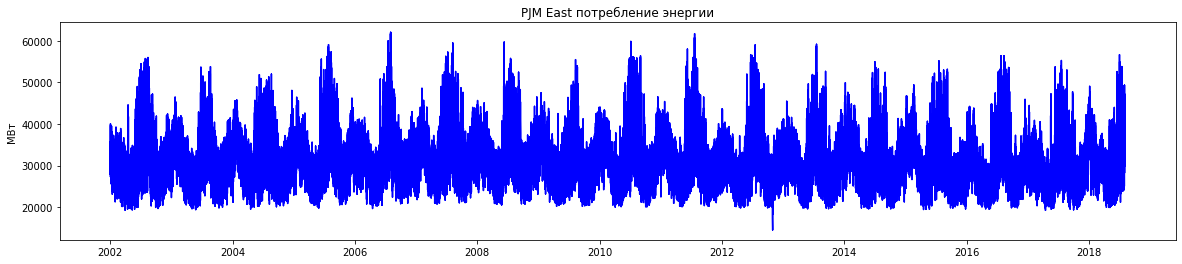

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

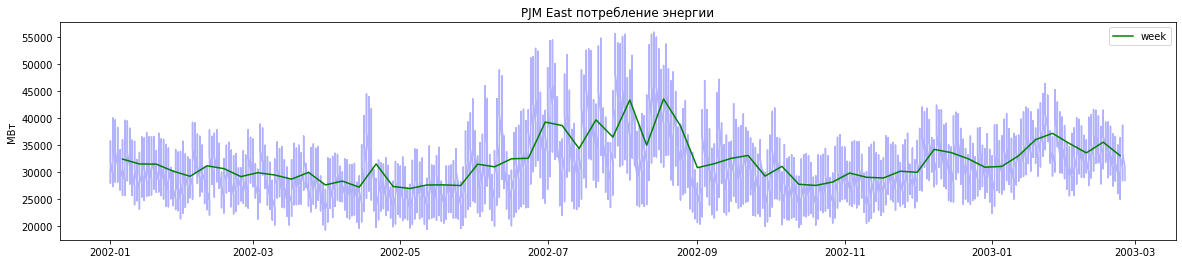

In [5]:
data_d = data.copy().resample('D').mean()
data_w = data.resample('W').mean()


plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

__2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .__

In [6]:
import statsmodels.api as sm

test_ADF = sm.tsa.stattools.adfuller(data_w['PJME_MW'].values, regression='ctt')
test_ADF

(-13.618743234517284,
 3.178551840146982e-22,
 11,
 854,
 {'1%': -4.384748970317034,
  '5%': -3.839322655125974,
  '10%': -3.5575526054344873},
 15405.229437796354)

In [7]:
test_ADF = sm.tsa.stattools.adfuller(data_w['PJME_MW'].values[:26], regression='ctt')
test_ADF

(2.1307450103906067,
 1.0,
 9,
 16,
 {'1%': -5.316864912109375, '5%': -4.2791632421875, '10%': -3.818178115234375},
 280.0217939009577)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
YMW_pca = pca.fit_transform(data_w.iloc[:,1:])
YMW_pca.shape

(866, 2)

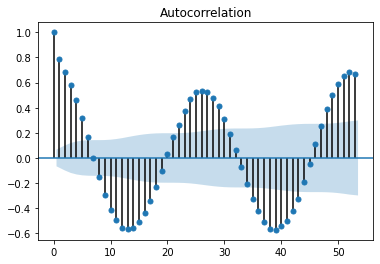

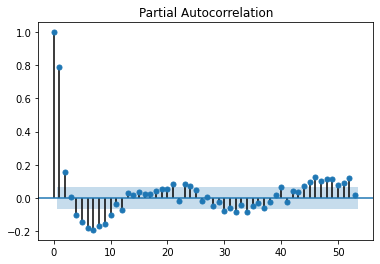

In [9]:
data_w['pca1']=YMW_pca[:,0]
data_w['pca2']=YMW_pca[:,1]
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=53)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=53)
plt.show()

Сезонрость по году видим в начале и в конце, чтр бы не захватить все возьмем 53 недели

In [10]:
p = 53
for i in range(p):
    data_w[f't{p-i}']=0
    data_w[f't{p-i}'].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

k = 13
for i in range(k):
    data_w[f'd{k-i}']=0
    data_w[f'd{k-i}'].values[k:] = data_w['diff1'].values[i:-(k)+i]

сглаживание

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

__h = 4__

In [12]:
from sklearn.preprocessing import StandardScaler
scl_target=StandardScaler() 

h = 4

target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

# Входные признаки

scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape



(809, 86)

In [13]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)

sfk =SelectKBest(f_regression, k=10)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 10)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(809, 10)

In [14]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших баллов : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели градиентного бустинга: ',list_param_m)

Номера признаков k лучших баллов :  [16 17 18 19 20 30 31 32 57 58]
Номера признаков лучших признаков по процентной форме:  [16 17 18 19 20 30 31 32 57]
Номера признаков для выбора по модели градиентного бустинга:  [ 5 11 17 18 19 31 32 43 44 45]


In [15]:
list_param = [ 0, 14, 15, 16, 17, 18, 28, 29, 30]
X_new = X[:,list_param]
data_w.columns[list_param]

Index(['PJME_MW', 't52', 't51', 't50', 't49', 't48', 't38', 't37', 't36'], dtype='object')

In [16]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

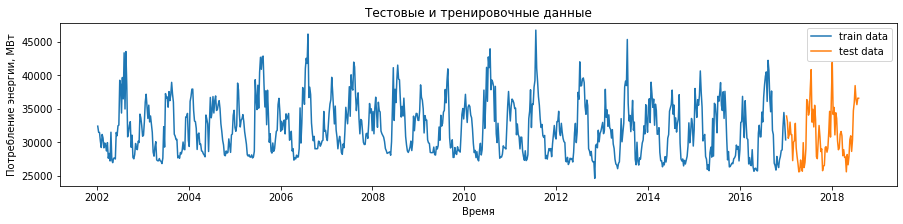

In [17]:
train, test = split_data( data_w, '01-01-2017')

plt.figure( figsize=( 15, 3 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [18]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [19]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100)
model_g.fit( X_train, y_train )
y_test_pred_g = model_g.predict(X_test)

model_l = LinearRegression()
model_l.fit( X_train, y_train )
y_test_pred_l = model_l.predict(X_test)

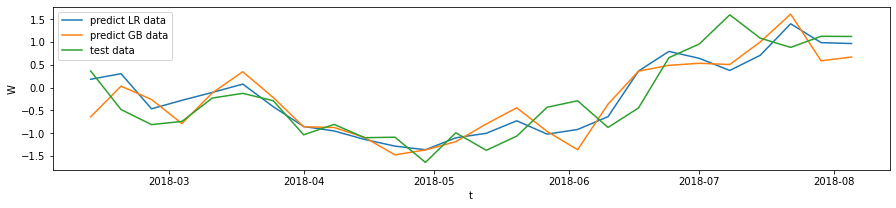

In [20]:
plt.figure( figsize=( 15, 3 ))

plt.xlabel('t')
plt.ylabel('W')
plt.plot(test.index[h+p:],y_test_pred_l, label='predict LR data' )
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
er_l = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_l))
print('ошибка LR MAPE :  ', er_l,'%')

ошибка градиентного бустинга MAPE :   5.587598458357258 %
ошибка LR MAPE :   4.397308479839633 %


Модель линейной регресси чуть лучше градиентнго бустинга

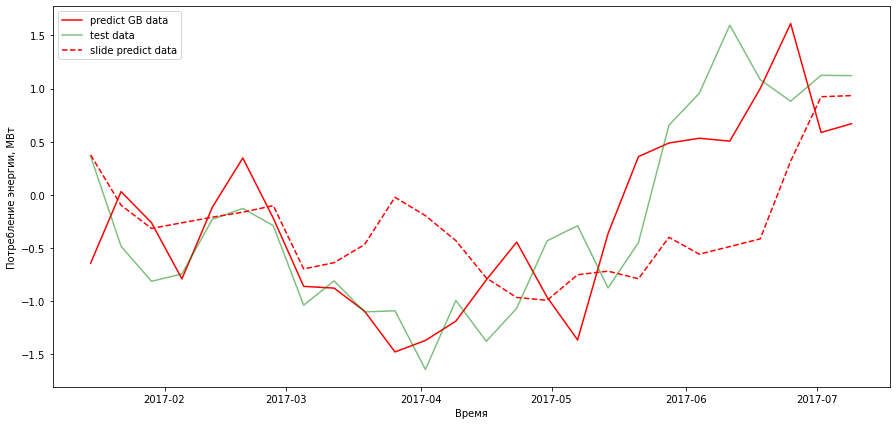

In [23]:
X_test_100 = X_test.copy()
X_test_100 = np.vstack([X_train[-p-h:,:],X_test_100])
y_test_100 = y_test_pred_g.copy()
y_test_100 = np.hstack([y_train[-p-h:],y_test_100])
N10 = 26
for ip in range(N10):
    i=ip+p 
    # делаю отступ р для использования данных на первом шаге рекурсии
    y_test_100[i] = model_l.predict(X_test_100[i,:].reshape((1,9)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    X_test_100[i+1,1] = X_test_100[i-53+1,0]
    X_test_100[i+1,2] = X_test_100[i-52+1,0]
    X_test_100[i+1,3] = X_test_100[i-51+1,0]
    X_test_100[i+1,4] = X_test_100[i-50+1,0]
    X_test_100[i+1,5] = X_test_100[i-49+1,0]
    X_test_100[i+1,6] = X_test_100[i-38+1,0]
    X_test_100[i+1,7] = X_test_100[i-56+1,0]
    X_test_100[i+1,8] = X_test_100[i-1+1,0]

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[p:N10+p], '--r',label='slide predict data')

plt.legend()
plt.show()       

In [29]:
er_100 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_100[p+1:]))
print('ошибка LR MAPE :  ', er_100,'%')

ошибка LR MAPE :   5.060632879857328 %


In [24]:
h = 1

# целевой признак
scl_target=StandardScaler() 
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

# Входные признаки

scl_x=StandardScaler() 
X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

sfk =SelectKBest(f_regression, k=10)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=500).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 10)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших баллов : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели градиентного бустинга: ',list_param_m) 

Номера признаков k лучших баллов :  [ 0 13 14 15 16 17 28 29 64 65]
Номера признаков лучших признаков по процентной форме:  [ 0 13 14 15 16 17 28 29 65]
Номера признаков для выбора по модели градиентного бустинга:  [ 0 14 15 16 17 30 55]


In [25]:
list_param = [ 0, 14, 15, 16, 17, 18, 28, 29]
X_new = X[:,list_param]
data_w.columns[list_param]

Index(['PJME_MW', 't52', 't51', 't50', 't49', 't48', 't38', 't37'], dtype='object')

# на h=1 так же как и на h=4 признаки почти совпадают

In [26]:
len(test),len(test.index[1+p:]),len(y_test_pred_l), len(X_test), len(X_new), len(X), '(83, 29, 26, 26, 809, 812)'


(83, 29, 26, 26, 812, 812, '(83, 29, 26, 26, 809, 812)')

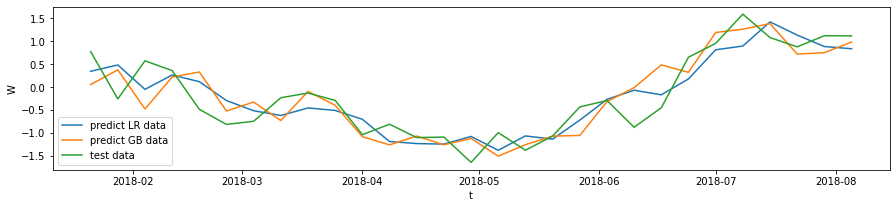

ошибка градиентного бустинга MAPE :   4.798039611815999 %
ошибка LR MAPE :   4.567446399153212 %


In [27]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]



model_g = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100)
model_g.fit( X_train, y_train )
y_test_pred_g = model_g.predict(X_test)

model_l = LinearRegression()
model_l.fit( X_train, y_train )
y_test_pred_l = model_l.predict(X_test)

plt.figure( figsize=( 15, 3 ))

plt.xlabel('t')
plt.ylabel('W')
plt.plot(test.index[h+p:],y_test_pred_l, label='predict LR data' )
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
er_l = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_l))
print('ошибка LR MAPE :  ', er_l,'%')

__Вывод__ : линейная регрессия показала лучший результат и h=1 и h=4

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

r2_score(y_test, y_test_pred_l)

0.7823120669800033